### 1 Loading Dataset

In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from my_datasets import MyDataset1
from my_models import MyModel1
from data.delta_transform import delta_data
MODEL_PATH = './mynet.pth'
#from my_models_CNN import MyModel_CNN
#from data.model_input import state_on
#from data.model_gt import label_on
from data.model_input_off import state_on, input_4, input_5, input_6, input_0
from data.model_gt_off import label_on, label_4, label_5, label_6, label_0

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [4]:
### get the rotation matrix
def rotation_matrix(theta):
    theta = (theta+2*np.pi)%(2*np.pi)
    return np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

In [5]:
rotation_matrix(-0.1)

array([[ 0.99500417,  0.09983342],
       [-0.09983342,  0.99500417]])

In [6]:
'''
to_angle = 180 / np.pi
#### conpute the delta imformation from the original information
ROOT = './data/'
out = open(ROOT+"delta_transform.py",'w')
delta_data = np.empty((0,7))
with open(ROOT+"offdata.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        ### for the target vehicle
        x1 = float(words[1])
        y1 = float(words[2])
        the1 = (float(words[3])+2*np.pi)%(2*np.pi)
        Tr1 = np.array([[np.cos(the1), -np.sin(the1), x1],
                        [np.sin(the1), np.cos(the1), y1], 
                        [0,0,1]])
        ### for the ego vehicle
        x2 = float(words[5])
        y2 = float(words[6])
        the2 = (float(words[7])+2*np.pi)%(2*np.pi)
        Tr2 = np.array([[np.cos(the2), -np.sin(the2), x2],
                        [np.sin(the2), np.cos(the2), y2], 
                        [0,0,1]])
        Tr21 = np.linalg.inv(Tr2).dot(Tr1)
        delta_x = Tr21[0,2]
        delta_y = Tr21[1,2]
        #print(Tr21[1,0])
        delta_theta = np.arcsin(Tr21[1,0])
        if delta_x >= 0:
            newline = np.array([[delta_x, delta_y, delta_theta,
                                 float(words[4]), float(words[8]),  
                                 float(words[9]), float(words[10])]])
            delta_data = np.append(delta_data, newline, axis=0)
        
np.set_printoptions(threshold = np.inf)
out.write(str(repr(np.array(delta_data))))
out.close()
'''

'\nto_angle = 180 / np.pi\n#### conpute the delta imformation from the original information\nROOT = \'./data/\'\nout = open(ROOT+"delta_transform.py",\'w\')\ndelta_data = np.empty((0,7))\nwith open(ROOT+"offdata.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        ### for the target vehicle\n        x1 = float(words[1])\n        y1 = float(words[2])\n        the1 = (float(words[3])+2*np.pi)%(2*np.pi)\n        Tr1 = np.array([[np.cos(the1), -np.sin(the1), x1],\n                        [np.sin(the1), np.cos(the1), y1], \n                        [0,0,1]])\n        ### for the ego vehicle\n        x2 = float(words[5])\n        y2 = float(words[6])\n        the2 = (float(words[7])+2*np.pi)%(2*np.pi)\n        Tr2 = np.array([[np.cos(the2), -np.sin(the2), x2],\n                        [np.sin(the2), np.cos(the2), y2], \n                        [0,0,1]])\n        Tr21 = np.linalg.inv(Tr2).dot(Tr1)\n        delta_x = Tr21[0,2]\n  

In [7]:
'''
# Dataset & Dataloader  
#### test data
np.random.shuffle(delta_data) 
test_data = delta_data[60000:,:]
state_test = test_data[:, :5]
label_test= test_data[:, 5:]
test_data = MyDataset1(states = state_test, labels = label_test)
print("Test size: %i" % len(test_data))
'''

'\n# Dataset & Dataloader  \n#### test data\nnp.random.shuffle(delta_data) \ntest_data = delta_data[60000:,:]\nstate_test = test_data[:, :5]\nlabel_test= test_data[:, 5:]\ntest_data = MyDataset1(states = state_test, labels = label_test)\nprint("Test size: %i" % len(test_data))\n'

In [8]:

#### training data
training_data = delta_data
np.random.shuffle(training_data) 
#print(training_data[52960])
print(np.min(training_data[:,2]))
state_train = training_data[:60000, :5]
label_train = training_data[:60000, 5:]
state_val = training_data[60000:, :5]
label_val = training_data[60000:, 5:] 
state_over = training_data[:4, :5]
label_over = training_data[:4, 5:]

train_data = MyDataset1(states = state_train, labels = label_train)
val_data = MyDataset1(states = state_val, labels = label_val)   
overtest_data = MyDataset1(states = state_over, labels = label_over)

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)
overtest_loader = DataLoader(dataset=overtest_data, batch_size=32, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Overtest size: %i" % len(overtest_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1])


-1.54105334
Train size: 60000
Validation size: 3012
Overtest size: 4
Input size:  (5,)
Label size:  0.756546957


In [9]:
'''
# Dataset & Dataloader  
weight = np.array([[1,1]])
data_on = np.concatenate((state_on, label_on*weight), axis = 1) 
data_off_0 = np.concatenate((input_0, label_0*weight), axis = 1) 
data_off_4 = np.concatenate((input_4, label_4*weight), axis = 1) 
data_off_5 = np.concatenate((input_5, label_5*weight), axis = 1) 
data_off_6 = np.concatenate((input_6, label_6*weight), axis = 1) 
data_all = np.concatenate((data_on, data_on, data_on, data_on, data_off_0, data_off_4, data_off_5, data_off_6), axis = 0)
data_all = np.column_stack(((data_all[:,:3] - data_all[:,4:7]), data_all[:,3], data_all[:,7], data_all[:,8:10]))
print(data_all[0])
np.random.shuffle(data_all) 
state_train = data_all[:30000, :5]
label_train = data_all[:30000, 5:]
state_val = data_all[30000:, :5]
label_val = data_all[30000:, 5:] 

train_data = MyDataset1(states = state_train, labels = label_train)
val_data = MyDataset1(states = state_val, labels = label_val)   

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)
'''

'\n# Dataset & Dataloader  \nweight = np.array([[1,1]])\ndata_on = np.concatenate((state_on, label_on*weight), axis = 1) \ndata_off_0 = np.concatenate((input_0, label_0*weight), axis = 1) \ndata_off_4 = np.concatenate((input_4, label_4*weight), axis = 1) \ndata_off_5 = np.concatenate((input_5, label_5*weight), axis = 1) \ndata_off_6 = np.concatenate((input_6, label_6*weight), axis = 1) \ndata_all = np.concatenate((data_on, data_on, data_on, data_on, data_off_0, data_off_4, data_off_5, data_off_6), axis = 0)\ndata_all = np.column_stack(((data_all[:,:3] - data_all[:,4:7]), data_all[:,3], data_all[:,7], data_all[:,8:10]))\nprint(data_all[0])\nnp.random.shuffle(data_all) \nstate_train = data_all[:30000, :5]\nlabel_train = data_all[:30000, 5:]\nstate_val = data_all[30000:, :5]\nlabel_val = data_all[30000:, 5:] \n\ntrain_data = MyDataset1(states = state_train, labels = label_train)\nval_data = MyDataset1(states = state_val, labels = label_val)   \n\ntrain_loader = DataLoader(dataset=train_da

### 2 Defining Neural Network

In [10]:
#mynet = MyModel1(neurons = [512,2048,512]).to(device)
mynet = MyModel1(neurons = [256, 1024, 256]).to(device)
print(mynet)

MyModel1(
  (predictor): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [11]:
#mynet.load_state_dict(torch.load(MODEL_PATH))
#mynet.to(device)

In [12]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

530,690 total parameters.
530,690 trainable parameters.


### 3 Training Neural network

In [13]:
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [28]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss1 = 0.0  
    running_loss2 = 0.0
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y1, y2 = data
        X = X.to(device)
        y1 = y1.to(device).float()
        y2 = y2.to(device).float()
        #print(X.shape,y.shape)
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X.to(torch.float32))
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2) 
            loss = loss1 + loss2
            loss.backward()             
            optimizer.step()            
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item() 
            #print('x', X)
            #print('prediction', y_pred1)
            #print('gt', y1)
        else:
            y_pred = model(X.to(torch.float32)) 
            y_pred1 = y_pred[:,0].float()
            y_pred2 = y_pred[:,1].float()
            loss1 = criterion(y_pred1, y1)
            loss2 = criterion(y_pred2, y2) 
            loss = loss1 + loss2 
            running_loss1 += loss1.item() 
            running_loss2 += loss2.item()     
    return running_loss1, running_loss2

In [21]:
# test if the model will overfit with only one sample
max_epochs = 2000
train_history_th = []
train_history_st = []
val_history_th = []
val_history_st = []
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
#scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs): 
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    scheduler.step()
    '''
    train_loss1, train_loss2 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=overtest_loader,
                           iftrain=True)
    train_history_th.append(train_loss1)
    train_history_st.append(train_loss2)
    val_loss1, val_loss2 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=overtest_loader,
                           iftrain=False)
    val_history_th.append(val_loss1)
    val_history_st.append(val_loss2)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1: >3}/{max_epochs} \nThrottle: train_loss: %2e, val_loss: %2e \nSteering Angle: train_loss: %2e, val_loss: %2e "% 
          (train_loss1, val_loss1, train_loss2, val_loss2))
        #print(scheduler.get_last_lr())

prediction tensor([0.0589, 0.6303, 0.7992, 0.6012], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.2958, 0.9106, 1.1147, 0.0686], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.1515,  1.2561,  0.8695, -0.1047], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([-0.1333,  1.0529,  1.0778,  0.7627], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 0.6957, -0.0627,  0.9852,  0.8987], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([0.8493, 0.6867, 0.0483, 0.9237], device='cuda:0',
       grad_fn=<Sel

prediction tensor([0.9979, 0.9966, 0.0013, 0.7589], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([-0.0014,  0.7593,  0.9995,  0.9978], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([-0.0031,  0.9999,  1.0010,  0.7581], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0017, -0.0024,  1.0015,  0.7564], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0019e+00, 1.0379e-04, 1.0014e+00, 7.5517e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([0.0022, 1.0003, 1.0013, 0.7549], device='cuda:0',
   

prediction tensor([-1.6898e-04,  9.9993e-01,  7.5676e-01,  9.9967e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([9.9995e-01, 9.9984e-01, 3.9767e-07, 7.5657e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([7.5638e-01, 9.9981e-01, 1.0002e+00, 1.9140e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([9.9986e-01, 1.9902e-04, 1.0003e+00, 7.5629e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 2.2115e-05, 7.5635e-01, 1.0001e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tenso

prediction tensor([ 9.9996e-01,  1.0000e+00, -1.4787e-05,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([ 7.5655e-01,  9.9996e-01,  1.0000e+00, -1.7988e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5656e-01, -5.7053e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 9.9999e-01, 2.3618e-06, 7.5656e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([9.9997e-01, 7.5654e-01, 1.0000e+00, 2.4075e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
predicti

prediction tensor([ 7.5655e-01, -2.8880e-06,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 1.4817e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 3.3891e-06, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 1.5674e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -1.2564e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction t

prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 2.5053e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([7.5655e-01, 2.2817e-07, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 1.0000e+00, 1.6857e-07, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 1.6484e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 1.1269e-07, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([7

gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([5.6811e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
Epoch 300/2000 
Throttle: train_loss: 6.135934e-15, val_loss: 9.279253e-15 
Steering Angle: train_loss: 1.891065e-15, val_loss: 1.308198e-15 
prediction tensor([7.1712e-08, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([1.2107e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00, -1.7695e-08,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cu

gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 6.4261e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 6.4261e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([-4.7497e-08,  7.5655e-01,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([-2.1420e-08,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([-5.1223e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tenso

prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -1.0245e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -1.0245e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([1.9558e-08, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 1.9558e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 1.5832e-08, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction t

prediction tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.8184e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -2.5146e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([-2.5146e-08,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -6.5193e-09,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 9.4064e-08, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
predicti

prediction tensor([ 1.0000e+00, -2.1420e-08,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -4.3772e-08,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -5.8673e-08,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -1.4808e-07,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 7.5655e-01, -1.0338e-07,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')


prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -4.0047e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00, -3.2596e-08,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([-5.1223e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01,  1.0000e+00, -2.7940e-09], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([3.8184e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
pred

prediction tensor([7.5655e-01, 3.0734e-08, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 7.1712e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.1642e-07, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([-4.3772e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([-1.1828e-07,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction t

prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 6.4261e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00, -3.2596e-08,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([-7.7300e-08,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 7.5655e-01, -6.6124e-08,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([-2.1420e-08,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
pred

prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 1.7229e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 5.3085e-08, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 7.5655e-01, -2.5611e-07,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([-2.5239e-07,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.6112e-07, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction t

prediction tensor([ 7.5655e-01, -2.2259e-07,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -8.8476e-08,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([1.0151e-07, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([2.1700e-07, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 2.2445e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction t

prediction tensor([-0.0625,  0.9949,  1.0428,  0.7220], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([0.1336, 0.9098, 1.0029, 0.8178], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 0.6825,  1.1413, -0.1729,  0.9899], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([0.8544, 1.0174, 0.7992, 0.0717], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([0.0988, 1.0037, 0.7854, 1.0544], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0756,  0.6729, -0.1291,  0.9615], device='cuda:0',
       grad_fn=<Sel

prediction tensor([-0.0018,  0.9993,  0.9994,  0.7558], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 0.9996,  1.0005,  0.7573, -0.0012], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([1.0006, 0.7575, 0.0013, 1.0007], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([0.7558, 0.9994, 0.0010, 0.9999], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 9.9937e-01, -9.1768e-04,  7.5540e-01,  9.9968e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0006e+00,  1.0004e+00, -7.7993e-04,  7.5712e-01], 

prediction tensor([ 9.9995e-01,  1.0001e+00,  7.5664e-01, -1.0695e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 7.5665e-01, 7.5829e-05, 1.0001e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([9.9993e-01, 7.5646e-01, 7.9158e-05, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 9.9994e-01,  7.5644e-01,  9.9999e-01, -4.5779e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([-5.2339e-05,  1.0001e+00,  1.0000e+00,  7.5662e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
predicti

gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([-6.4783e-06,  9.9999e-01,  9.9999e-01,  7.5653e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00, -5.9688e-06,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([5.0496e-06, 1.0000e+00, 7.5656e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([9.9999e-01, 7.5654e-01, 9.9999e-01, 2.2380e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00,  9.9999e-01,  7.5654e-01, -2.5788e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tenso

prediction tensor([-1.3923e-06,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00, -3.8277e-07,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 1.0431e-06, 1.0000e+00, 7.5654e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([7.5654e-01, 1.0000e+00, 1.1586e-06, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 5.9325e-07, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction t

prediction tensor([7.5655e-01, 1.8403e-06, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -1.8673e-06,  7.5654e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([-1.7099e-06,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.2042e-06, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([1.2107e-06, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction t

prediction tensor([ 7.5655e-01, -7.6368e-08,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
Epoch 1200/2000 
Throttle: train_loss: 3.076792e-14, val_loss: 3.666598e-14 
Steering Angle: train_loss: 2.258827e-15, val_loss: 2.575392e-14 
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -3.1665e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 1.6764e-08, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 1.0000e+00, 8.7544e-08, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.7323e-07, 1.0000e+00

prediction tensor([3.1665e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 9.3132e-09, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([2.4214e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -3.1665e-08,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -6.1467e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction t

prediction tensor([1.0000e+00, 3.1665e-08, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -2.0489e-08,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00, -6.1467e-08,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([-5.7742e-08,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 7.5655e-01, -3.5390e-08,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
pred

prediction tensor([7.5655e-01, 9.3132e-09, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -5.5879e-09,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -5.5879e-09,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00, -1.8626e-09,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 9.3132e-09, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
predicti

gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00, -2.0489e-08,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00, -4.2841e-08,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 5.0291e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([5.4017e-08, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 6.8918e-08, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7

prediction tensor([1.8626e-09, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([-3.5390e-08,  1.0000e+00,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00, -6.5193e-08,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([-6.1467e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00, -6.1467e-08,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
pred

prediction tensor([1.0000e+00, 5.4017e-08, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 5.0291e-08, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([-1.3039e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01,  1.0000e+00, -2.0489e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([-5.5879e-09,  7.5655e-01,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
predicti

gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 5.5879e-09], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([-4.2841e-08,  7.5655e-01,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -2.4214e-08,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -1.3039e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -9.3132e-09], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt t

prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -8.3819e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 9.3132e-09, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 6.5193e-08, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 1.0000e+00, 6.5193e-08, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([6.5193e-08, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tenso

prediction tensor([2.4214e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 1.8626e-09, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([2.0489e-08, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -4.2841e-08,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([-3.9116e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction t

gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 1.0000e+00, 5.7742e-08, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 8.0094e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 8.0094e-08, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([2.7940e-08, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.8626e-09, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-1

prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -1.5460e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00,  7.5655e-01, -1.2107e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 1.0000e+00, -4.2841e-08,  7.5655e-01,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([6.1467e-08, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 1.3039e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
predicti

gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([1.0151e-07, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([1.0000e+00, 3.4459e-08, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -1.3970e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([-1.0245e-08,  7.5655e-01,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00, -4.7497e-08,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tenso

prediction tensor([1.0000e+00, 4.5635e-08, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00, -2.6077e-08,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([ 1.0000e+00,  1.0000e+00, -3.7253e-08,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 1.4901e-08, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([4.4703e-08, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction t

prediction tensor([4.0047e-08, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
prediction tensor([-8.3819e-09,  7.5655e-01,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01,  1.0000e+00, -8.3819e-09], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -3.0734e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 7.5655e-01, -1.2107e-08,  1.0000e+00,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 3.9351e-15, 1.0000e+00, 1.0000e+00], device='cuda:0')
pred

prediction tensor([1.4901e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([3.7253e-08, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00, -7.0781e-08,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -9.6858e-08], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([-5.2154e-08,  1.0000e+00,  1.0000e+00,  7.5655e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 1.0000e+00, 1.0000e+00, 7.5655e-01], device='cuda:0')
predicti

gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 7.4506e-09], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 2.0489e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([ 7.5655e-01,  1.0000e+00,  1.0000e+00, -2.6077e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([7.5655e-01, 1.0000e+00, 1.0000e+00, 3.9351e-15], device='cuda:0')
prediction tensor([1.0000e+00, 7.5655e-01, 2.6543e-07, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 7.5655e-01, 3.9351e-15, 1.0000e+00], device='cuda:0')
prediction tensor([ 1.0000e+00,  7.5655e-01, -3.8743e-07,  1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1

prediction tensor([0.9769, 0.0029, 0.7355, 0.9795], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 3.9351e-15, 7.5655e-01, 1.0000e+00], device='cuda:0')
prediction tensor([-0.0216,  0.7464,  0.9825,  0.9999], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([-0.0076,  0.7781,  1.0248,  1.0098], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([3.9351e-15, 7.5655e-01, 1.0000e+00, 1.0000e+00], device='cuda:0')
prediction tensor([1.0038, 1.0192, 0.0086, 0.7589], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 3.9351e-15, 7.5655e-01], device='cuda:0')
prediction tensor([0.9770, 1.0035, 0.7389, 0.0138], device='cuda:0',
       grad_fn=<SelectBackward0>)
gt tensor([1.0000e+00, 1.0000e+00, 7.5655e-01, 3.9351e-15], device='cuda:0')
prediction tensor([ 7.5661e-01, -4.9599e-05,  9.8440e-01,  9.9041e-01], device='cuda:0',
   

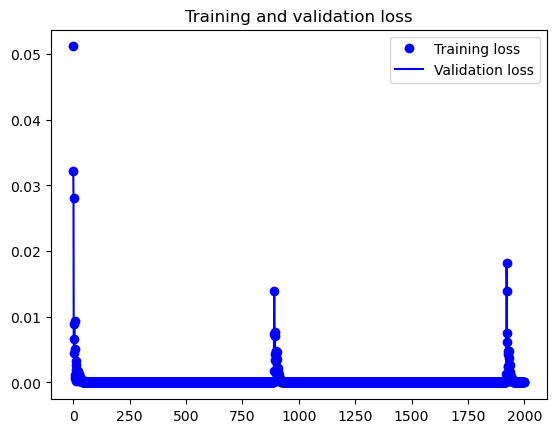

In [25]:
## Throttle
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history_th))
plt.figure()
plt.plot(epochs, train_history_th, 'bo', label='Training loss')
plt.plot(epochs, val_history_th, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

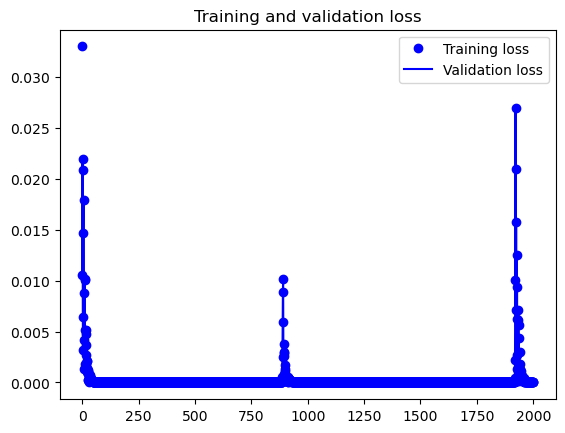

In [26]:
## Steering Angle
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history_st))
plt.figure()
plt.plot(epochs, train_history_st, 'bo', label='Training loss')
plt.plot(epochs, val_history_st, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [27]:
TEST = random.randint (0, 3)
test_in, gt_th, gt_st  = overtest_data[TEST]
gt_output = [gt_th, gt_st]
test_in = torch.tensor(test_in).to(device)
gt_output = torch.tensor(gt_output).to(device)
mynet.eval()
output_pred = mynet(test_in.to(torch.float32).unsqueeze(0)) 
print('TEST', TEST)
print('test_in',test_in)
print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

TEST 3
test_in tensor([13.4888,  1.7509,  0.1941,  9.8300,  6.5605], device='cuda:0',
       dtype=torch.float64)
prediction:[[0.9990192 0.239196 ]], ground truth:[1.         0.23729001]


In [29]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/32) 
train_history_th = []
train_history_st = []
val_history_th = []
val_history_st = []

min_loss = 100000
current_patience = 0
patience = 5



In [31]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 
max_epochs = 200
print('Start training!')
for epoch in range(max_epochs): 
    
    if epoch >= 999 and epoch <= 1999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 1999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    
    train_loss1, train_loss2 = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history_th.append(train_loss1/num_trainbatch)
    train_history_st.append(train_loss2/num_trainbatch)
    val_loss1, val_loss2 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history_th.append(val_loss1/num_valbatch)
    val_history_st.append(val_loss2/num_valbatch)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1: >3}/{max_epochs} \nThrottle: train_loss: %2e, val_loss: %2e \nSteering Angle: train_loss: %2e, val_loss: %2e "% 
          (train_loss1/num_trainbatch, val_loss1/num_valbatch, train_loss2/num_trainbatch, val_loss2/num_valbatch))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch  10/200 
Throttle: train_loss: 8.466224e-04, val_loss: 1.656791e-03 
Steering Angle: train_loss: 2.020395e-03, val_loss: 4.051876e-03 
Epoch  20/200 
Throttle: train_loss: 8.075651e-04, val_loss: 1.634562e-03 
Steering Angle: train_loss: 1.922572e-03, val_loss: 3.917406e-03 
Epoch  30/200 
Throttle: train_loss: 7.929423e-04, val_loss: 1.711937e-03 
Steering Angle: train_loss: 1.881215e-03, val_loss: 3.994468e-03 


KeyboardInterrupt: 

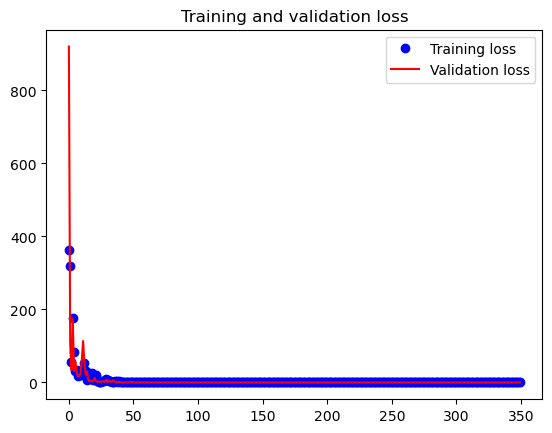

In [30]:
# plot the train&validation loss curve 
epochs = range(len(train_history_th))
plt.figure()
plt.plot(epochs, train_history_th, 'bo', label='Training loss')
plt.plot(epochs, val_history_th, 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [34]:
# save trained model
torch.save(mynet.state_dict(),'mynet_transform_2561024256.pth')

In [22]:
mynet.load_state_dict(torch.load('mynet.pth', map_location='cpu'))

<All keys matched successfully>

In [38]:
######inference with validation data
for i in range (11):
    TEST = random.randint (0, 3012)
    test_in,gt_th, gt_st= val_data[TEST]
    gt_output = [gt_th, gt_st]
    test_in = torch.tensor(test_in).to(device)
    gt_output = torch.tensor(gt_output).to(device)
    mynet.eval()
    
    output_pred = mynet(test_in.to(torch.float32).unsqueeze(0)) 
    print('TEST', TEST)
    print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

TEST 1256
prediction:[[ 0.40066433 -0.00345853]], ground truth:[ 4.01040627e-01 -6.85543800e-05]
TEST 2558
prediction:[[0.81157285 0.17484558]], ground truth:[0.80704278 0.18592475]
TEST 1943
prediction:[[ 0.3541013  -0.02495263]], ground truth:[ 0.35523092 -0.02393529]
TEST 2766
prediction:[[ 1.0095011 -0.7921079]], ground truth:[ 1.         -0.76567423]
TEST 684
prediction:[[-0.01559399  0.7923956 ]], ground truth:[1.0478588e-15 7.7955748e-01]
TEST 472
prediction:[[1.0060705 0.0710809]], ground truth:[1.         0.07313895]
TEST 2117
prediction:[[ 0.0061145  -0.04870095]], ground truth:[ 0.         -0.06682152]
TEST 1094
prediction:[[1.0188066 1.012719 ]], ground truth:[1. 1.]
TEST 1608
prediction:[[0.00748246 0.04313546]], ground truth:[ 1.50422374e-14 -3.42229731e-02]
TEST 2143
prediction:[[-0.00839807 -0.05470891]], ground truth:[ 3.47320917e-15 -6.25364310e-02]
TEST 749
prediction:[[1.0030063 0.0552591]], ground truth:[1.         0.05571012]


In [37]:
######inference with test data
for i in range (11):
    TEST = i
    test_in,gt_output = test_data[TEST]
    test_in = torch.tensor(test_in).to(device)
    gt_output = torch.tensor(gt_output).to(device)
    mynet.eval()
    output_pred = mynet(test_in.to(torch.float32).unsqueeze(0)) 
    print('TEST', TEST)
    print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

NameError: name 'test_data' is not defined

In [76]:
test_on =  delta_data[22223+200:22227+200,:]
state_test = test_on[:, :5]
label_test= test_on[:, 5:]
test_data = MyDataset1(states = state_test, labels = label_test)
test_in,gt_output = test_data[0]
test_in = torch.tensor(test_in).to(device)
gt_output = torch.tensor(gt_output).to(device)
mynet.eval()
output_pred = mynet(test_in.to(torch.float32).unsqueeze(0)) 
print('test_in',test_in)
print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

test_in tensor([-8.9859, 10.1089,  2.1939, 12.4875, 15.8320], device='cuda:0',
       dtype=torch.float64)
prediction:[[-0.05717424 -0.031052  ]], ground truth:[ 1.02965816e-13 -4.80149322e-04]
